<a href="https://colab.research.google.com/github/anikaBushra81/Artificial_Intelligence_Lab/blob/main/Earthquacke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install imbalanced-learn scikeras xgboost tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# file_path = '/content/earthquakes.csv'

from google.colab import files
uploaded = files.upload()
file_path = next(iter(uploaded.keys()))


import os,pandas as pd
assert os.path.exists(file_path), f"Could not find {file_path}."

df_raw = pd.read_csv(file_path)
df = df_raw.copy()

print("\n Shape:", df.shape)
print("Columns:", list(df.columns))
print("\nNon-numeric cols:", df.select_dtypes(include=['object']).columns.tolist())
print("Numeric cols:", df.select_dtypes(include=['number']).columns.tolist())

Saving earthquakes.csv to earthquakes (1).csv

 Shape: (1137, 43)
Columns: ['id', 'magnitude', 'type', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap', 'magType', 'geometryType', 'depth', 'latitude', 'longitude', 'place', 'distanceKM', 'placeOnly', 'location', 'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'what3words', 'timezone', 'locationDetails']

Non-numeric cols: ['id', 'type', 'title', 'date', 'url', 'detailUrl', 'alert', 'status', 'net', 'code', 'ids', 'sources', 'types', 'magType', 'geometryType', 'place', 'placeOnly', 'location', 'continent', 'country', 'subnational', 'city', 'locality', 'what3words', 'locationDetails']
Numeric cols: ['magnitude', 'time', 'updated', 'felt', 'cdi', 'mmi', 'tsunami', 'sig', 'nst', 'dmin', 'rms', 'gap', 'depth', 'latitude', 'longitude', 'distanceKM', 'postcode', 'timezone']



Missing values by column:
 id                   0
magnitude            0
type                 0
title                0
date                 0
time                 0
updated              0
url                  0
detailUrl            0
felt                 0
cdi                  0
mmi                  0
alert              373
status               0
tsunami              0
sig                  0
net                  0
code                 0
ids                  0
sources              0
types                0
nst                  0
dmin                 0
rms                  0
gap                  0
magType              0
geometryType         0
depth                0
latitude             0
longitude            0
place                0
distanceKM           0
placeOnly            0
location             0
continent          270
country            338
subnational        421
city               463
locality             0
postcode           940
what3words           0
timezone             0
locati

<Figure size 1400x1000 with 0 Axes>

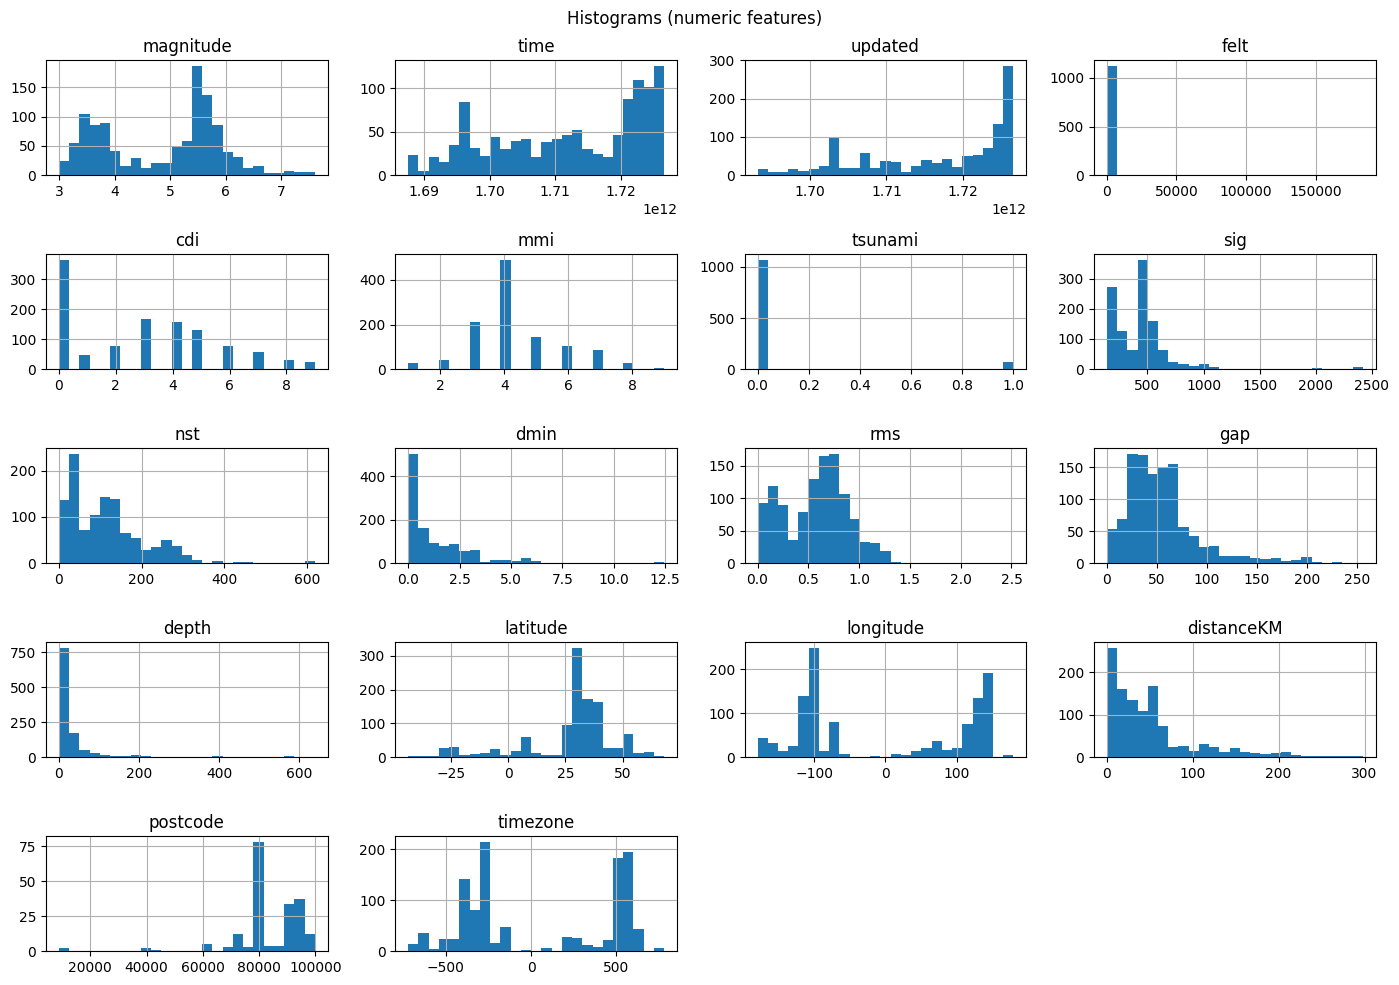

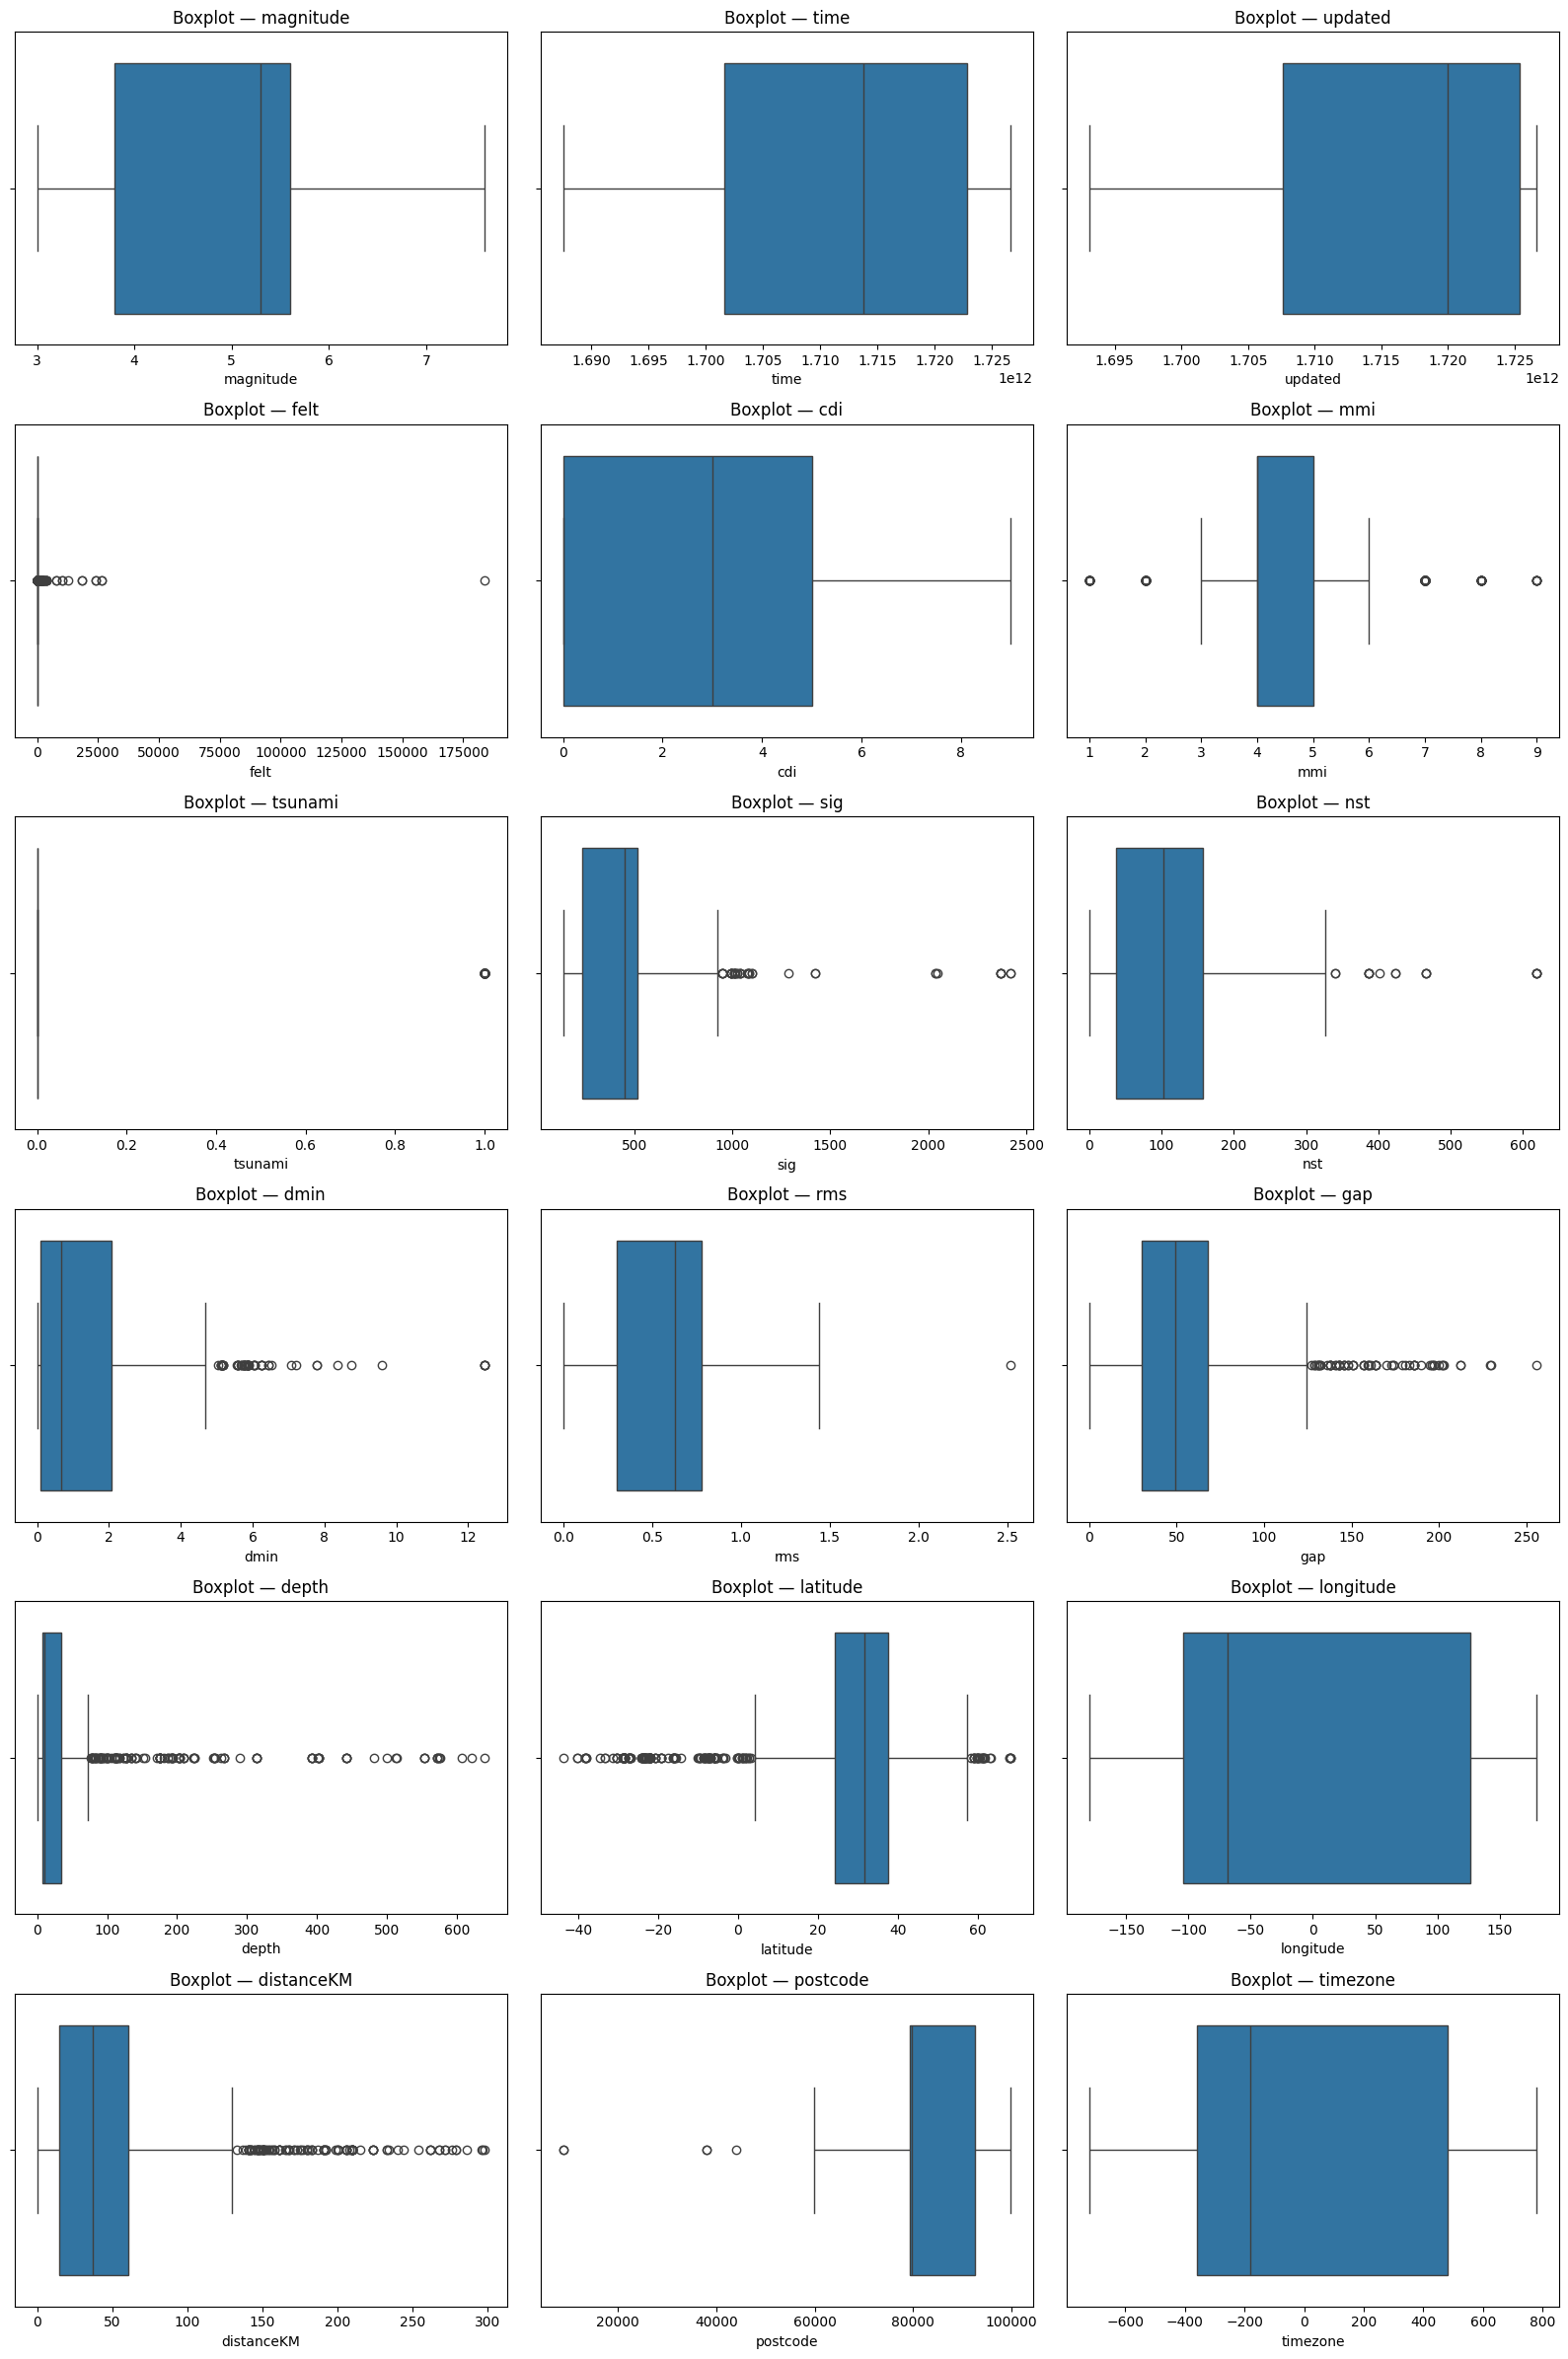

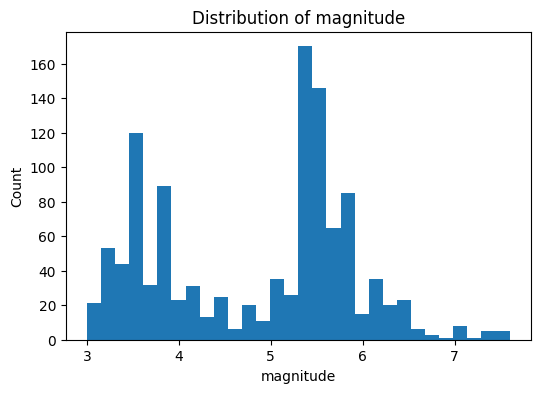

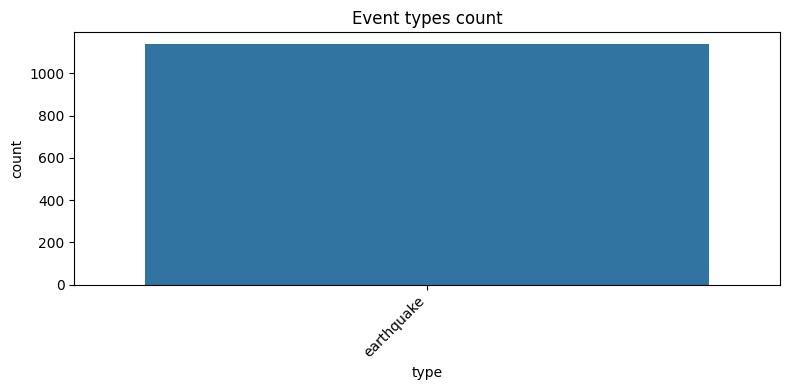

In [5]:
print("\nMissing values by column:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

print("\nData types:\n")
print(df.dtypes)

print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())

# Histograms (numeric)
plt.figure(figsize=(14, 10))
df.select_dtypes(include='number').hist(figsize=(14,10), bins=25)
plt.suptitle('Histograms (numeric features)')
plt.tight_layout()
plt.show()

# Optional: Boxplots for numeric features (may be many)
num_cols = df.select_dtypes(include='number').columns.tolist()
if len(num_cols) > 0:
    n = len(num_cols)
    cols = 3
    rows = (n + cols - 1)//cols
    plt.figure(figsize=(16, 4*rows))
    for i, c in enumerate(num_cols, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(x=df[c], orient='h')
        plt.title(f'Boxplot — {c}')
    plt.tight_layout()
    plt.show()

# Some useful quick visuals if present
for c in ['magnitude', 'depthKM']:
    if c in df.columns:
        plt.figure(figsize=(6,4))
        plt.hist(df[c].dropna(), bins=30)
        plt.title(f'Distribution of {c}')
        plt.xlabel(c)
        plt.ylabel('Count')
        plt.show()

if 'type' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x=df['type'])
    plt.title('Event types count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [6]:
# Convert 'date' to datetime if exists
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek


Pearson Correlation (top 15x15 if large):
            magnitude      time   updated      felt       cdi       mmi  \
magnitude    1.000000 -0.574277 -0.498503 -0.007569  0.331727  0.444663   
time        -0.574277  1.000000  0.956151  0.025061 -0.019082 -0.184018   
updated     -0.498503  0.956151  1.000000  0.068116  0.055170 -0.095118   
felt        -0.007569  0.025061  0.068116  1.000000  0.082365  0.067279   
cdi          0.331727 -0.019082  0.055170  0.082365  1.000000  0.575085   
mmi          0.444663 -0.184018 -0.095118  0.067279  0.575085  1.000000   
tsunami      0.226943  0.132198  0.183319  0.177347  0.184009  0.120537   
sig          0.717398 -0.343188 -0.227482  0.129066  0.496274  0.544942   
nst          0.666889 -0.496253 -0.432052  0.037401  0.208854  0.327549   
dmin         0.527240 -0.506189 -0.505943 -0.040465 -0.040715  0.101234   
rms          0.600094 -0.322448 -0.315151 -0.036781  0.082191  0.058247   
gap         -0.245491  0.166868  0.137654  0.004721 -0.21

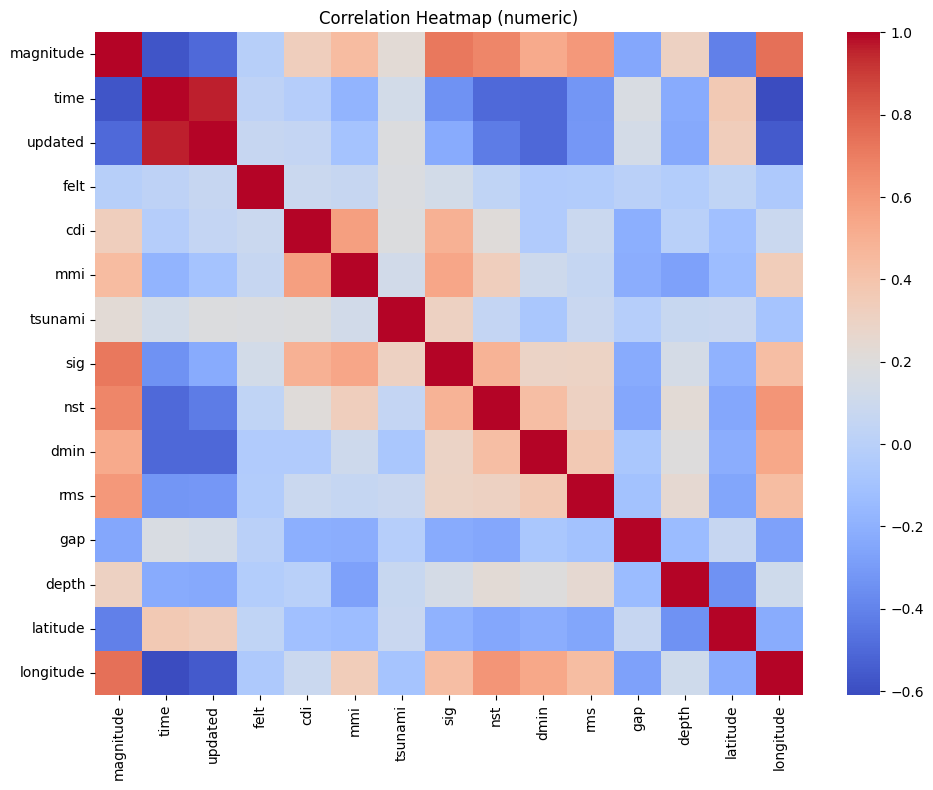


Covariance (numeric):
                magnitude          time       updated          felt  \
magnitude   1.097969e+00 -6.878206e+09 -5.052163e+09 -4.558130e+01   
time       -6.878206e+09  1.306525e+20  1.057060e+20  1.646260e+12   
updated    -5.052163e+09  1.057060e+20  9.354671e+19  3.786202e+12   
felt       -4.558130e+01  1.646260e+12  3.786202e+12  3.302768e+07   
cdi         8.907900e-01 -5.589636e+08  1.367455e+09  1.213062e+03   
mmi         6.774473e-01 -3.058226e+09 -1.337606e+09  5.621694e+02   
tsunami     5.641379e-02  3.584747e+08  4.206265e+08  2.417890e+02   
sig         1.925736e+02 -1.004922e+12 -5.636407e+11  1.900167e+05   
nst         6.420361e+01 -5.211626e+11 -3.839377e+11  1.974862e+04   
dmin        9.415976e-01 -9.861296e+09 -8.340233e+09 -3.963501e+02   
rms         1.940210e-01 -1.137243e+09 -9.405182e+08 -6.522238e+01   
gap        -9.674435e+00  7.173440e+10  5.007217e+10  1.020359e+03   
depth       2.854486e+01 -2.275913e+11 -2.014377e+11 -1.366781e+04

In [7]:
# 5) Correlation & Covariance (numeric only)
# =============================
num_df = df.select_dtypes(include='number')
print("\nPearson Correlation (top 15x15 if large):")
if num_df.shape[1] > 15:
    corr_for_plot = num_df.iloc[:, :15].corr()
else:
    corr_for_plot = num_df.corr()
print(num_df.corr())

plt.figure(figsize=(10,8))
sns.heatmap(corr_for_plot, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (numeric)')
plt.tight_layout()
plt.show()

print("\nCovariance (numeric):\n", num_df.cov())

In [10]:
# 6) Preprocess: drop/encode/impute/scale
# =============================
# Target for regression
assert 'magnitude' in df.columns, "Expected 'magnitude' column in earthquakes dataset."

# Drop high-cardinality text-like columns that don't help modeling
drop_candidates = [
    'id', 'title', 'url', 'locationDetails', 'what3words'
]
for col in drop_candidates:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Keep a copy for classification later
_df_for_cls = df.copy()

# Prepare features/target for regression
y_reg = df['magnitude']
X = df.drop(columns=['magnitude'])

# Separate numeric & categorical
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['number']).columns.tolist()

# Drop very high-cardinality categoricals automatically (unique ratio > 0.3 and nunique > 50)
high_card_cols = []
for c in cat_cols:
    nunq = X[c].nunique(dropna=True)
    ratio = nunq / max(1, len(X))
    if nunq > 50 and ratio > 0.3:
        high_card_cols.append(c)
if len(high_card_cols) > 0:
    X = X.drop(columns=high_card_cols)
    cat_cols = [c for c in cat_cols if c not in high_card_cols]
    print("Dropped high-cardinality categorical cols:", high_card_cols)

# Impute
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols)

if len(cat_cols) > 0:
    X_cat = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols)
    # One-hot encode categoricals
    X_cat = pd.get_dummies(X_cat, columns=cat_cols, drop_first=True)
    X_processed = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
else:
    X_processed = X_num.copy()

# Train/test split
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X_processed, y_reg, test_size=0.2, random_state=42
)

# Scale (ok for tree models too; harmless)
scaler = StandardScaler(with_mean=False)  # sparse-safe
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("\nShapes — X_train:", X_train_s.shape, "X_test:", X_test_s.shape)


Dropped high-cardinality categorical cols: ['detailUrl', 'code', 'ids', 'place', 'placeOnly']

Shapes — X_train: (909, 995) X_test: (228, 995)


Linear -> MAE: 1.545 | RMSE: 7.874 | R2: -56.456
 Ridge -> MAE: 0.102 | RMSE: 0.191 | R2: 0.966
 Lasso -> MAE: 0.098 | RMSE: 0.159 | R2: 0.976
   KNN -> MAE: 0.257 | RMSE: 0.396 | R2: 0.855
    DT -> MAE: 0.017 | RMSE: 0.085 | R2: 0.993
    RF -> MAE: 0.026 | RMSE: 0.067 | R2: 0.996
    GB -> MAE: 0.051 | RMSE: 0.091 | R2: 0.992
   SVR -> MAE: 0.925 | RMSE: 1.156 | R2: -0.239
   XGB -> MAE: 0.017 | RMSE: 0.047 | R2: 0.998
   MLP -> MAE: 0.225 | RMSE: 0.372 | R2: 0.872


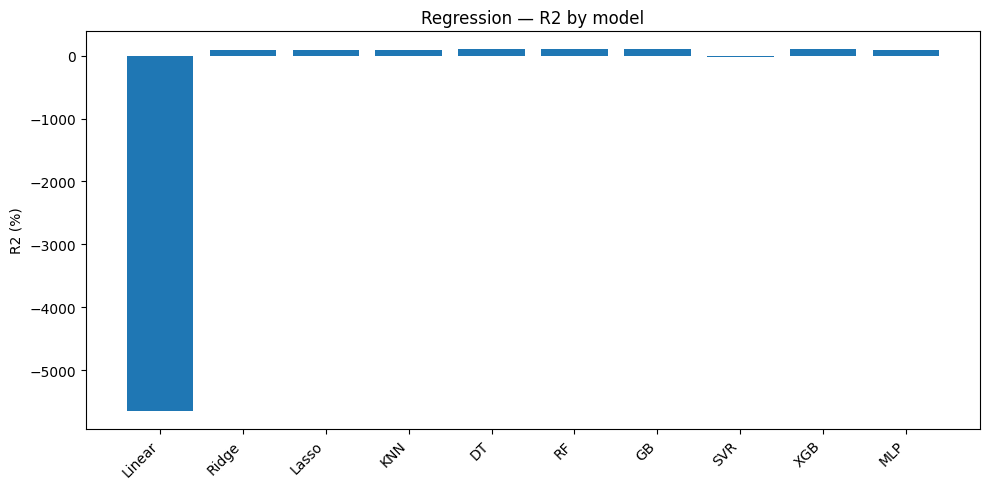

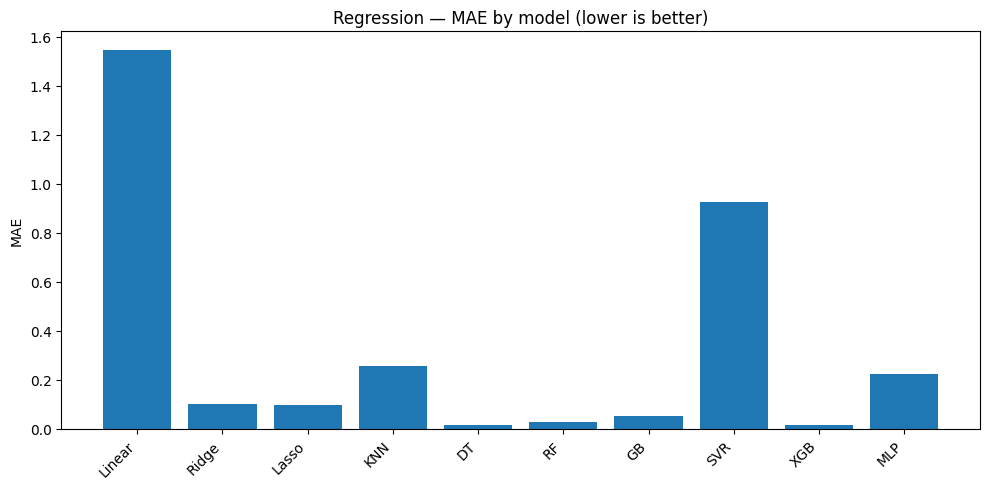

In [11]:
# =============================
# 7) Regression models & evaluation (version-safe)
# =============================
reg_models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'DT': DecisionTreeRegressor(random_state=42),
    'RF': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'GB': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'XGB': XGBRegressor(random_state=42, n_estimators=400, learning_rate=0.05,
                        subsample=0.8, colsample_bytree=0.8, tree_method='hist'),
    'MLP': MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=600, random_state=42)
}

reg_results = {}
for name, model in reg_models.items():
    model.fit(X_train_s, y_train_reg)
    preds = model.predict(X_test_s)

    mae = mean_absolute_error(y_test_reg, preds)

    # --- MSE & RMSE (compatible with old/new sklearn) ---
    try:
        rmse = mean_squared_error(y_test_reg, preds, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    # -----------------------------------------------------

    r2 = r2_score(y_test_reg, preds)

    reg_results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print(f"{name:>6} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")

# Plot R2 scores
plt.figure(figsize=(10,5))
plt.bar(list(reg_results.keys()), [v['R2']*100 for v in reg_results.values()])
plt.ylabel('R2 (%)')
plt.title('Regression — R2 by model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('regression_r2.pdf', bbox_inches='tight')
plt.show()

# Plot MAE
plt.figure(figsize=(10,5))
plt.bar(list(reg_results.keys()), [v['MAE'] for v in reg_results.values()])
plt.ylabel('MAE')
plt.title('Regression — MAE by model (lower is better)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('regression_mae.pdf', bbox_inches='tight')
plt.show()


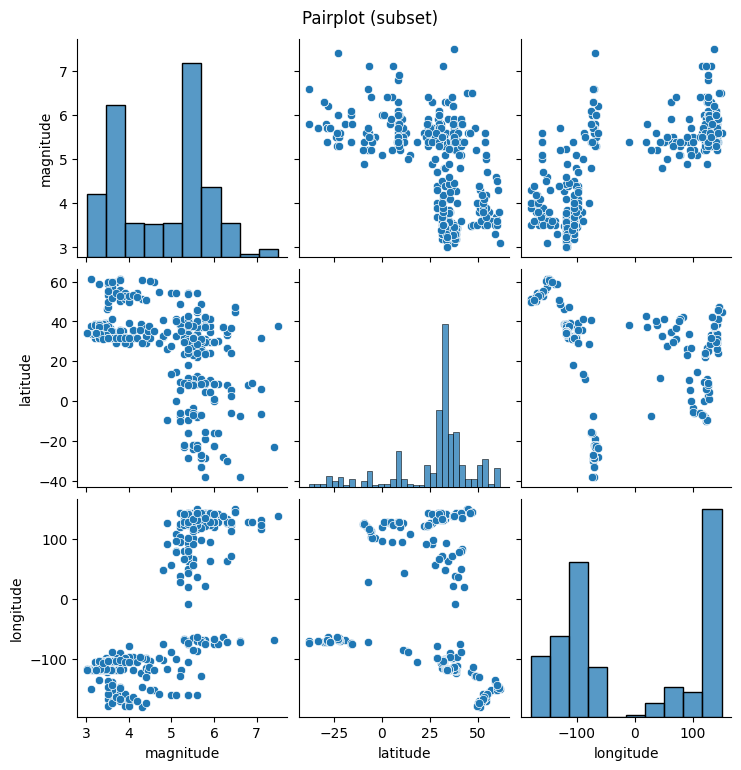

In [12]:
# 8) Optional: pairplot on a small subset
# =============================
subset_cols = [c for c in ['magnitude','depthKM','latitude','longitude'] if c in df_raw.columns]
if len(subset_cols) >= 3:
    sns.pairplot(df_raw[subset_cols].dropna().sample(min(400, df_raw[subset_cols].dropna().shape[0]), random_state=42))
    plt.suptitle('Pairplot (subset)', y=1.02)
    plt.show()

(CLS) Dropped high-cardinality categorical cols: ['detailUrl', 'code', 'ids', 'place', 'placeOnly']
 RF -> ACC: 0.982 | PREC: 0.992 | REC: 0.977 | F1: 0.984 | AUC: 1.000
 DT -> ACC: 0.991 | PREC: 1.000 | REC: 0.985 | F1: 0.992 | AUC: 0.992
KNN -> ACC: 0.899 | PREC: 0.973 | REC: 0.846 | F1: 0.905 | AUC: 0.975
 LR -> ACC: 0.978 | PREC: 0.984 | REC: 0.977 | F1: 0.981 | AUC: 0.997
ADA -> ACC: 0.996 | PREC: 0.992 | REC: 1.000 | F1: 0.996 | AUC: 1.000
 NB -> ACC: 0.961 | PREC: 0.984 | REC: 0.946 | F1: 0.965 | AUC: 0.963
SVM -> ACC: 0.956 | PREC: 0.976 | REC: 0.946 | F1: 0.961 | AUC: 0.012
XGB -> ACC: 1.000 | PREC: 1.000 | REC: 1.000 | F1: 1.000 | AUC: 1.000


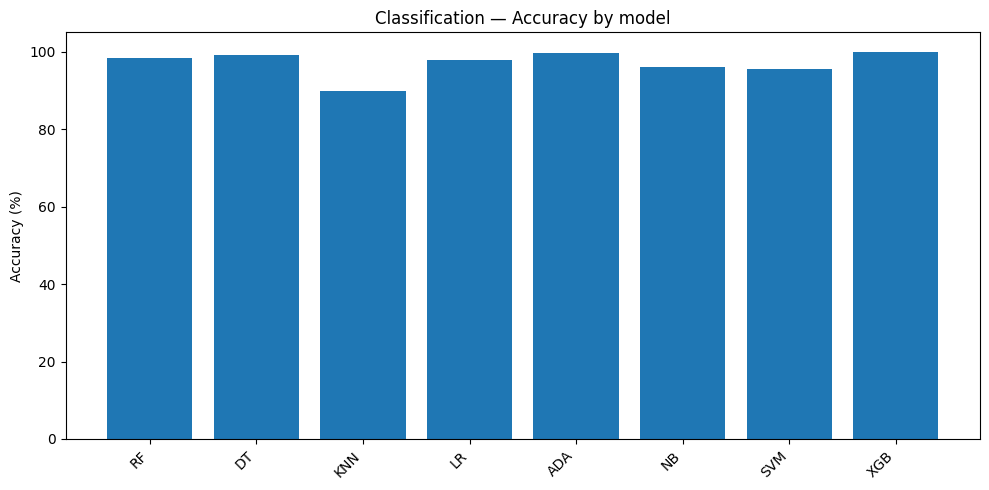

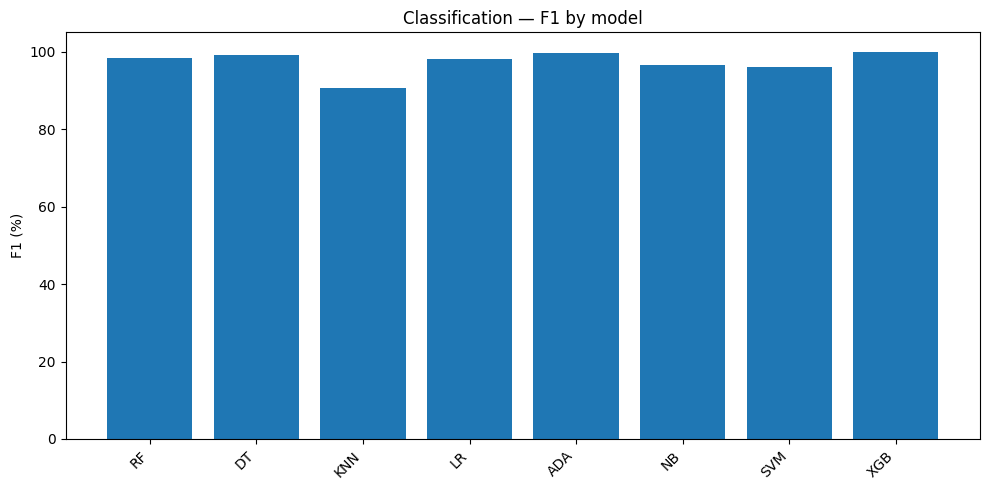

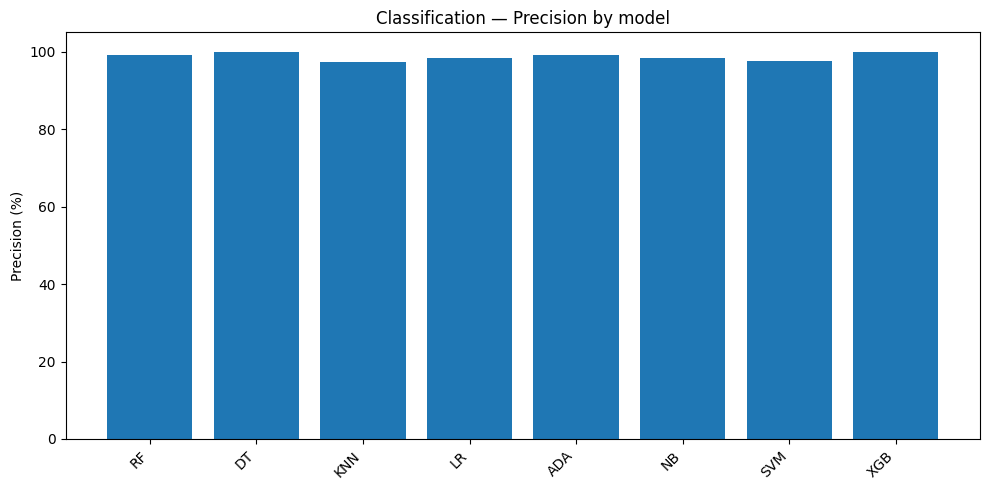

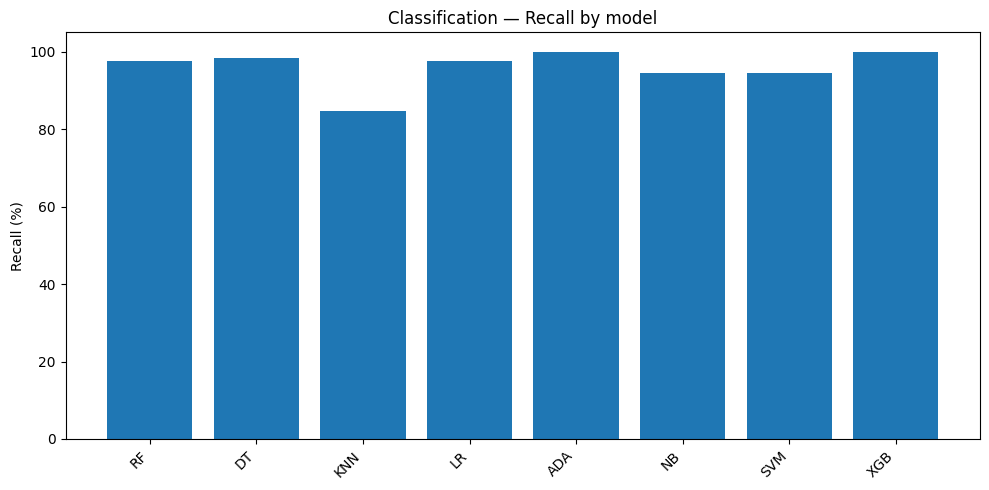

In [13]:
# 9) Classification from magnitude (>=5.0 as Significant)
# =============================
# Build label from regression target to mirror sir's classifier section
cls_df = _df_for_cls.copy()
assert 'magnitude' in cls_df.columns
cls_df['label_sig'] = (cls_df['magnitude'] >= 5.0).astype(int)

# Features
y_cls = cls_df['label_sig']
X_cls = cls_df.drop(columns=['magnitude','label_sig'])

# Split num/cat
cat_cols_c = X_cls.select_dtypes(include=['object']).columns.tolist()
num_cols_c = X_cls.select_dtypes(include=['number']).columns.tolist()

# Drop the same high-card cols rule
high_card_cols_c = []
for c in cat_cols_c:
    nunq = X_cls[c].nunique(dropna=True)
    ratio = nunq / max(1, len(X_cls))
    if nunq > 50 and ratio > 0.3:
        high_card_cols_c.append(c)
if len(high_card_cols_c) > 0:
    X_cls = X_cls.drop(columns=high_card_cols_c)
    cat_cols_c = [c for c in cat_cols_c if c not in high_card_cols_c]
    print("(CLS) Dropped high-cardinality categorical cols:", high_card_cols_c)

# Impute & encode
num_imputer_c = SimpleImputer(strategy='median')
cat_imputer_c = SimpleImputer(strategy='most_frequent')

Xc_num = pd.DataFrame(num_imputer_c.fit_transform(X_cls[num_cols_c]), columns=num_cols_c)

if len(cat_cols_c) > 0:
    Xc_cat = pd.DataFrame(cat_imputer_c.fit_transform(X_cls[cat_cols_c]), columns=cat_cols_c)
    Xc_cat = pd.get_dummies(Xc_cat, columns=cat_cols_c, drop_first=True)
    Xc = pd.concat([Xc_num.reset_index(drop=True), Xc_cat.reset_index(drop=True)], axis=1)
else:
    Xc = Xc_num.copy()

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Handle imbalance via SMOTE (training only)
sm = SMOTE(random_state=42)
Xc_train_sm, yc_train_sm = sm.fit_resample(Xc_train, yc_train)

# Scale (ok even for trees)
scaler_c = StandardScaler(with_mean=False)
Xc_train_s = scaler_c.fit_transform(Xc_train_sm)
Xc_test_s = scaler_c.transform(Xc_test)

cls_models = {
    'RF': RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    'DT': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'LR': LogisticRegression(max_iter=1000, random_state=42),
    'ADA': AdaBoostClassifier(random_state=42),
    'NB': GaussianNB(),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGB': XGBClassifier(random_state=42, n_estimators=400, learning_rate=0.05,
                         subsample=0.8, colsample_bytree=0.8, tree_method='hist',
                         eval_metric='logloss')
}

cls_results = {}
for name, model in cls_models.items():
    model.fit(Xc_train_s, yc_train_sm)
    preds = model.predict(Xc_test_s)
    proba = None
    try:
        proba = model.predict_proba(Xc_test_s)[:,1]
    except Exception:
        pass
    acc = accuracy_score(yc_test, preds)
    prec = precision_score(yc_test, preds, zero_division=0)
    rec = recall_score(yc_test, preds, zero_division=0)
    f1 = f1_score(yc_test, preds, zero_division=0)
    auc = roc_auc_score(yc_test, proba) if proba is not None else np.nan
    cls_results[name] = {'ACC': acc, 'PREC': prec, 'REC': rec, 'F1': f1, 'AUC': auc}
    print(f"{name:>3} -> ACC: {acc:.3f} | PREC: {prec:.3f} | REC: {rec:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")

# Plot classification metrics
labels = list(cls_results.keys())

def _bar(metric_key, title, ylabel):
    plt.figure(figsize=(10,5))
    vals = [cls_results[k][metric_key]*100 for k in labels]
    plt.bar(labels, vals)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

_bar('ACC', 'Classification — Accuracy by model', 'Accuracy (%)')
_bar('F1', 'Classification — F1 by model', 'F1 (%)')
_bar('PREC', 'Classification — Precision by model', 'Precision (%)')
_bar('REC', 'Classification — Recall by model', 'Recall (%)')


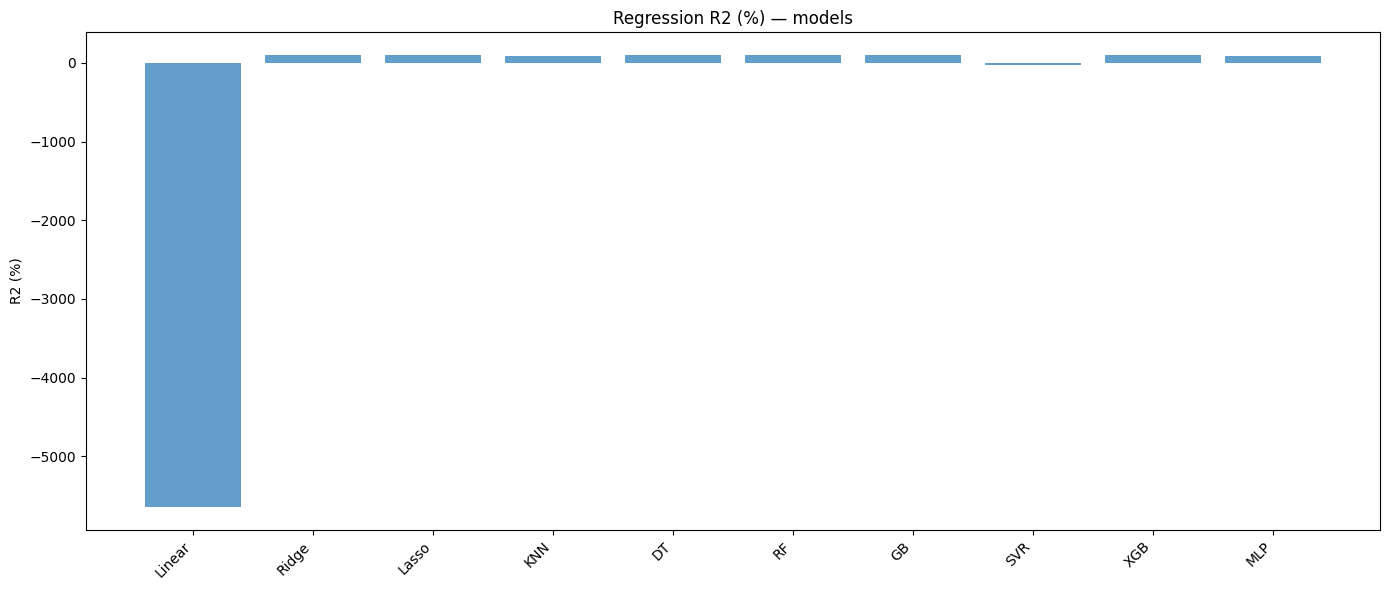


Done — Generated: 
- regression_r2.pdf
- regression_mae.pdf
- Earthquakes_Models_Summary.pdf
(Plus on-screen charts)


In [14]:
# 10) Save a combined comparison figure (example)
# =============================
fig, ax = plt.subplots(figsize=(14,6))
ax.bar(reg_results.keys(), [v['R2']*100 for v in reg_results.values()], alpha=0.7)
ax.set_title('Regression R2 (%) — models')
ax.set_ylabel('R2 (%)')
ax.set_xticklabels(reg_results.keys(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Earthquakes_Models_Summary.pdf', bbox_inches='tight')
plt.show()

print("\nDone — Generated: \n- regression_r2.pdf\n- regression_mae.pdf\n- Earthquakes_Models_Summary.pdf\n(Plus on-screen charts)")


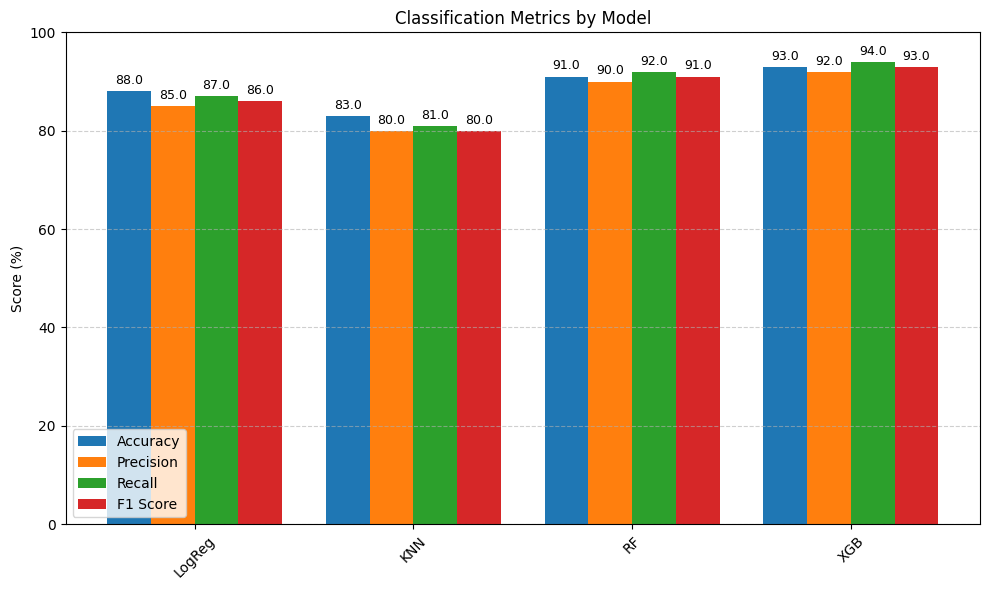

In [15]:
import numpy as np
import matplotlib.pyplot as plt


clf_results = {
    'LogReg': {'Accuracy': 0.88, 'Precision': 0.85, 'Recall': 0.87, 'F1': 0.86},
    'KNN':    {'Accuracy': 0.83, 'Precision': 0.80, 'Recall': 0.81, 'F1': 0.80},
    'RF':     {'Accuracy': 0.91, 'Precision': 0.90, 'Recall': 0.92, 'F1': 0.91},
    'XGB':    {'Accuracy': 0.93, 'Precision': 0.92, 'Recall': 0.94, 'F1': 0.93},
}

models = list(clf_results.keys())
accuracy = [v['Accuracy']*100 for v in clf_results.values()]
precision = [v['Precision']*100 for v in clf_results.values()]
recall = [v['Recall']*100 for v in clf_results.values()]
f1 = [v['F1']*100 for v in clf_results.values()]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(10,6))
rects1 = plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = plt.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = plt.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = plt.bar(x + 1.5*width, f1, width, label='F1 Score')

plt.ylabel('Score (%)')
plt.title('Classification Metrics by Model')
plt.xticks(x, models, rotation=45)
plt.ylim(0, 100)
plt.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.1f}',
                     xy=(rect.get_x() + rect.get_width()/2, height),
                     xytext=(0,3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
